In [1]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# הגדרות בסיס
IMAGE_SIZE = 256
DATA_PATH = "data" # וודא שתיקיית הדאטה נמצאת באותו מיקום של המחברת


In [2]:
class BDDDataset(Dataset):
    def __init__(self, root_dir, split="train"):
        self.images_dir = os.path.join(root_dir, "images", split)
        self.masks_dir = os.path.join(root_dir, "masks", split)
        
        if not os.path.exists(self.images_dir):
            raise FileNotFoundError(f"Missing images folder: {self.images_dir}")
            
        self.valid_pairs = []
        all_images = sorted(os.listdir(self.images_dir))
        
        # סריקת הקבצים וחיפוש זוגות
        for img_name in all_images:
            if not img_name.endswith(('.jpg', '.png')): continue
            
            base = os.path.splitext(img_name)[0]
            # תמיכה גם במסיכות ID (שחורות) וגם ב-Color
            found = False
            for suffix in ["_drivable_id.png", "_drivable_color.png"]:
                if os.path.exists(os.path.join(self.masks_dir, base + suffix)):
                    self.valid_pairs.append((img_name, base + suffix, "color" if "color" in suffix else "id"))
                    found = True
                    break
            
        print(f"[{split.upper()}] Dataset initialized with {len(self.valid_pairs)} images.")

    def __len__(self):
        return len(self.valid_pairs)

    def __getitem__(self, index):
        img_name, mask_name, mtype = self.valid_pairs[index]
        
        # טעינת תמונה
        img_path = os.path.join(self.images_dir, img_name)
        img = cv2.imread(img_path)
        if img is None: 
            raise ValueError(f"Could not load image: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # טעינת מסיכה
        mask_path = os.path.join(self.masks_dir, mask_name)
        mask = cv2.imread(mask_path)
        if mask is None:
            raise ValueError(f"Could not load mask: {mask_path}")
        
        # עיבוד המסיכה לפי הסוג שלה
        if mtype == "color":
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            # אדום או כחול = כביש
            mask = ((mask[:,:,0] > 100) | (mask[:,:,2] > 100)).astype(np.float32)
        else:
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            # 1=ראשי, 2=משני
            mask = np.where((mask==1)|(mask==2), 1.0, 0.0).astype(np.float32)

        # שינוי גודל (Resize)
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)

        # המרה ל-Tensor
        img = torch.tensor(img / 255.0).permute(2,0,1).float()
        mask = torch.tensor(mask).unsqueeze(0).float()
        
        return img, mask


In [3]:
def visualize_dataset(num_samples=5):
    print(f"Attempting to load data from '{DATA_PATH}'...")

    try:
        # יצירת ה-Dataset וה-Loader
        dataset = BDDDataset(root_dir=DATA_PATH, split="train")
        loader = DataLoader(dataset, batch_size=num_samples, shuffle=True)
        
        # שליפת באץ' אחד של נתונים
        # משתמשים ב-iter ו-next כדי לקבל דוגמאות אקראיות
        images, masks = next(iter(loader))
        print(f"Success! Displaying {num_samples} random samples:")

    except Exception as e:
        print(f"\nError: {e}")
        print("Tip: Make sure the 'data' folder structure is correct (images/train, masks/train).")
        return

    # --- יצירת הגרף ---
    plt.figure(figsize=(15, 4 * num_samples)) # גובה מותאם לכמות התמונות

    for i in range(num_samples):
        # 1. הצגת התמונה המקורית
        plt.subplot(num_samples, 2, 2*i + 1)
        # המרה מ-Tensor (C,H,W) ל-Numpy (H,W,C) לתצוגה
        img_show = images[i].permute(1, 2, 0).numpy()
        plt.imshow(img_show)
        plt.title(f"Original Image {i+1}")
        plt.axis('off')

        # 2. הצגת המסיכה (התשובה)
        plt.subplot(num_samples, 2, 2*i + 2)
        # הורדת מימד הערוץ (1,H,W) -> (H,W)
        mask_show = masks[i].squeeze().numpy()
        plt.imshow(mask_show, cmap='gray')
        plt.title(f"Label / Mask {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Attempting to load data from 'data'...
[TRAIN] Dataset initialized with 2352 images.
Success! Displaying 5 random samples:


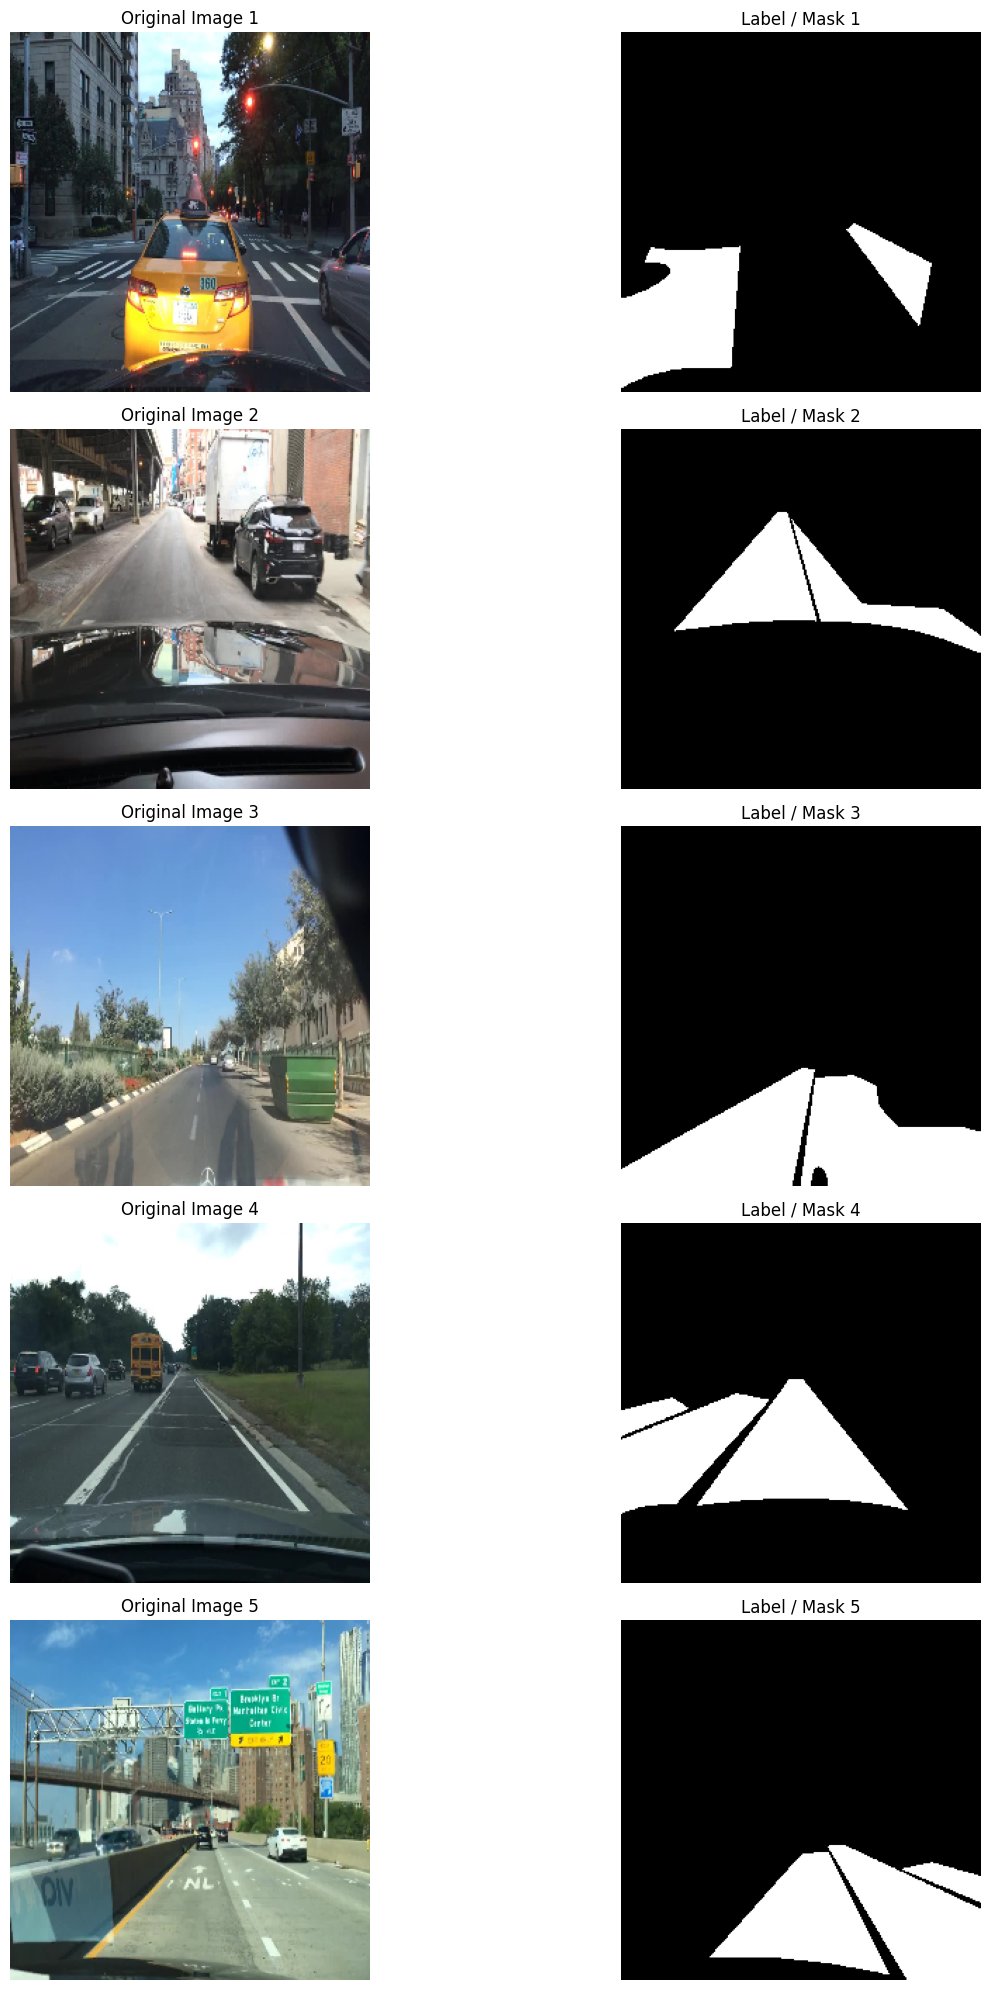

In [4]:
visualize_dataset(num_samples=5)
